## COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization
----------------------------------------------------------------------------------------

**(Semester 2, 2025)**

In this ipython notebook, we provide some example code for assignment1.
+ Load Data.
    - ORL dataset.
    - Extended YaleB dataset.
    - AR dataset (**optional**).
+ Perform Evaluation.
   - Relative Reconstruction Errors.
   - Accuracy, NMI (**optional**).

Lecturer: Tongliang Liu.

**Note: All datasets can be used only for this assignment and you are not allowed to distribute these datasets. If you want to use AR dataset, you need to apply it by yourself (we do not provide AR dataset due to the problem of license, please find more details in http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html).**

In [114]:
# Common
import os
import pandas as pd
import numpy as np
import json
import time
from PIL import Image
from collections import Counter, defaultdict

# Ploting
import matplotlib.pyplot as plt

# Evaluation 
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

#Experiment
from joblib import Parallel, delayed
import traceback

# Notebook variables
seed = 0
rng = np.random.default_rng(seed)

orl_data_location = 'data/ORL'
yaleB_data_location = 'data/CroppedYaleB'

## 1. Load Dataset

### 1.0 Data Folder

In [115]:
# Path to your dataset zip stored in Drive
zip_path = "data.zip"

# Unzip into Colab local filesystem
#!unzip -o -q "$zip_path" 

In [116]:
# The structure of data folder.
!ls -l data

total 0
drwxrwxrwx@ 41 jamie.saunders  staff  1312 Oct  4 14:21 CroppedYaleB
drwx------@ 44 jamie.saunders  staff  1408 Oct  4 14:37 ORL


### 1.1 Load ORL Dataset and Extended YaleB Dataset.
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [117]:
def load_data(root, reduce=3, normalization="per_image", eps=1e-12):
    """
    Load ORL (or Extended YaleB) dataset to numpy array.

    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.

    """
    images, labels = [], []
    height, width = 0, 0

    for i, person in enumerate(sorted(os.listdir(root))):

        if not os.path.isdir(os.path.join(root, person)):
            continue

        for fname in os.listdir(os.path.join(root, person)):

            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue

            if not fname.endswith('.pgm'):
                continue

            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.


            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # save the height/width after resizing
            if (height == 0 or width == 0):
              height = img.size[1]
              width = img.size[0]

            img = np.asarray(img, dtype=np.float32)

            # normalzation per image
            if normalization == "per_image":
              img = (img - img.min()) / (img.max() - img.min() + eps)

            img = img.reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    # normalize globally
    if normalization == "global":
      images = images.astype(np.float32)
      images = images / 255.0 # normalizing them


    return images, labels, height, width

# salt and pepper noise
def add_sp_noise(V_hat, p=0, r=0, rng=None):
  """
  Apply salt and pepper noise to an image dataset.

  Args:
    V_hat: dataset to create a copy of with noise applied
    p: hyperparameter to control the noise leve
    r: hyperparameter to control the ratio of white (salt) and black (pepper) pixels
    rng: 
  """
  if rng is None:
    rng = np.random.default_rng()

  m, n = V_hat.shape # n images, each has m pixels in a flat vector

  V_noise = V_hat.copy()

  for i in range(n): #iterate through each image
    for j in range(m): #iterate through each pixel
      if rng.random() < p: #we modify the pixel
        if rng.random() < r:
          V_noise[j, i] = 1.0 # turn the pixel white
        else:
          V_noise[j, i] = 0.0 # turn the pixel black

  return V_noise


# block occlusion noise
def add_block_noise(V_hat, h, w, log_return=False):
  """
  Apply block occlusion noise to an image dataset.

  Args:
    V_hat: dataset to create a copy of with noise applied
    r: hyperparameter to control the ratio of white (salt) and black (pepper) pixels
    log_return: boolean to drive the returning of logging details
  """
  m, n = V_hat.shape # n images, each has m pixels in a flat vector
  V_noise = V_hat.copy()
  min_square_size = m
  max_square_size = 0
  noise_log = []
  i = 0
  ii = 0

  for img in range(n): #iterate through each image
    square_size=np.random.uniform(.15, .3) * w
    min_square_size = min(min_square_size, square_size)
    max_square_size = max(max_square_size, square_size)
    # Random top-left corner, making sure the square fits in the image
    x = np.random.randint(0, w - square_size)
    y = np.random.randint(0, h - square_size)

    j = x + y * w 

    noise_log.append({"img":img, "start_index":j, "start_point":f"{x}-{y}", "square_size":square_size})
    # Set the square to white (255)
    while i < square_size:
      while ii < square_size:
        V_noise[j+ii][img] = 1

        ii = ii + 1

      i = i + 1
      ii = 0
      j = (i + y) * w + x
    i = 0
    ii = 0
    
  if log_return:
    print(f"Dimenstions (V_hat m): {m}")
    print(f"Images (V_hat n): {n}")
    print(f"Image width: {w}")
    print(f"Image height: {h}")
    print(f"min square size: {min_square_size}")
    print(f"max square size: {max_square_size}")
    print(json.dumps(noise_log, indent=4))

  return V_noise

---------------------------


## 2. Evaluation Metrics


### 2.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the ```relative reconstruction errors```. Let $V$ denote the contaminated dataset (by adding noise), and $\hat{V}$
 denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$, the ``relative reconstruction errors`` then can be defined as follows:
 \begin{equation}
    RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.
\end{equation}


In [118]:
# Defining NMF Funtions

# FSE method
def frobenius_squared_error(V, W, H):
  """
  Return frobenious squared reconstruction error

  Args:
    V: Original matrix
    W: Basis matrix
    H: Encoding matrix
  """
  WH = W @ H
  return np.sum((V - WH) ** 2)

def rre_fse(V_hat, W, H, eps=1e-12): 
  """
  Return relative reconstruction forbenious error

  Args:
    V: Original matrix (without noise)
    W: Basis matrix
    H: Encoding matrix
    eps:
  """
  WH = W @ H
  FE = np.linalg.norm( V_hat - WH, ord='fro')
  denom = np.linalg.norm(V_hat, ord='fro')
  RRE = FE / (denom + eps)
  return RRE

def fse_mur(V, W, H, max_iterations, tol, eps=1e-12, verbosity=1):
  """
  multiplicative update rules

  Args:
    V_hat: clean matrix (pre-noise)
    W: 
    H: 
    max_iterations:
    tol:
    eps:
  """

  if verbosity >= 1:
    print("Starting FSE MUR training...")
  errors = []
  prev = None

  iterations_done = 0

  for it in range(max_iterations):
      numerator_H = W.T @ V
      denominator_H = (W.T @ W @ H)

      H = H * numerator_H / (denominator_H + eps)

      numerator_W = V @ H.T
      denominator_W = (W @ H @ H.T)

      W = W * numerator_W / (denominator_W + eps)

      training_error = frobenius_squared_error(V, W, H)
      errors.append(training_error)
      iterations_done += 1

      if (iterations_done%100) == 0:
        if verbosity >= 1:
          print(f"Completed {iterations_done} iterations out of {max_iterations}")
        if verbosity >= 2:
          print(f"\t Training error = {training_error:.2f}")

      # check for early stopping
      if prev is None:
        prev = training_error
        continue

      if prev is not None:
        rel = abs(training_error - prev) / (abs(prev) + eps)
        if rel < tol: # if the curve has flattened too much or is going up
          if verbosity >= 1:
            print("Early stopping at iteration: ", it) # stop
          break
        prev = training_error

  if verbosity >= 1:
    print(f"Completed {iterations_done} iterations")

  return W, H, errors

def l21_norm(V, W, H): # finds the L_2,1 Norm objective function result
    """
    Return L21 norm reconstruction error

    Args:
      V: Original matrix
      W: Basis matrix
      H: Encoding matrix
    """
    R = V - W @ H
    return np.linalg.norm(R, axis=0).sum(0) #axis =0 means we go column by column

def compute_u(V, WH, eps=1e-12):
    """
    Computes u the vector instead of matrix U. Faster calculations

    Args:
      V: Original matrix
      W: Basis matrix
      H: Encoding matrix
      eps:
    """
    #change this as above
    R = V - WH
    col_norms = np.linalg.norm(R, axis=0) # gets a vector of all the norms of the columns of R
    u = 1.0 / np.maximum(col_norms, eps) # inverts them
    return u

def rre_l21_norm(V, W, H, eps=1e-12):
  """
  Computes u the vector instead of matrix U. Faster calculations

  Args:
    V: Original matrix
    W: Basis matrix
    H: Encoding matrix
    eps:
  """
  R = V - W @ H
  nom = np.linalg.norm(R, axis=0).sum(0)
  denom = np.linalg.norm(V, axis=0).sum(0)
  RRE = nom / (denom + eps)
  return RRE

def l21_norm_mur(V, W, H, max_iterations, tol, eps=1e-12, delta=1e-12, verbosity=1):
  """
  Calculates the H update and W update steps for L21 NMF

  Args:
    V_hat: clean matrix (pre-noise)
    W: 
    H: 
    max_iterations:
    tol:
    eps:
    delta:
    verbosity:
  """
  
  if verbosity >= 1:
    print("Staring L2,1 Norm NMF MUR training...")
  errors = []
  prev = None
  iterations_done = 0

  for it in range(max_iterations):
      # precompute some variables to save runtime
      WH = W @ H
      u = compute_u(V, WH, eps=eps) # finds u but as a vector, not full diagonal matrix U
      V_u = V * u

      numerator_H = W.T @ (V_u)
      denominator_H = W.T @ (WH * u) + delta # includes delta to avoid division by zero

      H *= numerator_H / denominator_H # updates H
      H = np.maximum(H, 0) # clips it to keep it non-negative

      WH = W@H # recompute now that we've updated H

      numerator_W = (V_u) @ H.T
      denominator_W = (WH * u) @ H.T + delta

      W *= numerator_W / denominator_W # updates W
      W = np.maximum(W, 0) # clips it to keep it non-negative

      training_error = l21_norm(V, W, H)
      errors.append(training_error) # tracks the objective function value at each update step
      iterations_done += 1

      if (iterations_done%100) == 0:
        if verbosity >= 1:
          print(f"Completed {iterations_done} iterations out of {max_iterations}")
        if verbosity >= 2:
          print(f"\tTraining error = {training_error:.2f}")

      # check for early stopping
      if prev is None:
        prev = training_error
        continue

      if prev is not None:
        rel = abs(training_error - prev) / (abs(prev) + eps)
        if rel < tol: # if the curve has flattened too much or is going up
          if verbosity >= 1:
            print("Early stopping at iteration: ", it) # stop
          break
        prev = training_error

  if verbosity >= 1:
    print(f"Completed {iterations_done} iterations")
  return W, H, errors


In [119]:
# randomly select 90%
def make_stratified_subset(V, Y, V_hat, frac=0.9, seed=0):
  """
  Calculates the H update and W update steps for L21 NMF

  Args:
    V: Original matrix
    Y: Target labels
    V_hat:
    frac:
    seed:
  """
  
  rng = np.random.default_rng(seed)
  labels = np.unique(Y)
  idx_trimmed = []
  # print(labels)
  for cls in labels:
    cls_idx = np.where(Y == cls)[0]
    amount_to_keep = int(frac * len(cls_idx))
    chosen = rng.choice(cls_idx, size=amount_to_keep, replace=False)
    idx_trimmed.extend(chosen)
  idx_trimmed = np.array(idx_trimmed)
  V_trimmed = V[:, idx_trimmed]
  Y_trimmed = Y[idx_trimmed]
  V_hat_trimmed = V_hat[:, idx_trimmed]
  return V_trimmed, Y_trimmed, V_hat_trimmed


### 2.2 Evaluate Clustering Performance

1. Accuracy.
    
    $$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1\{Y_{pred}(i) == Y(i)\}$$
        
2. Normalized Mutual Information (NMI).

    $$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
   where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

In [120]:
def assign_cluster_label(X, Y, verbosity=1):
  """
  Calculates the H update and W update steps for L21 NMF

  Args:
    X:
    Y:
    verbosity:
  """
  if verbosity >= 2:
    print("Num of classes = ", len(set(Y)))
  kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
  Y_pred = np.zeros(Y.shape)
  for i in set(kmeans.labels_):
      ind = kmeans.labels_ == i
      Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
  return Y_pred

In [121]:
# running the whole thing in one function
def run_config(config, verbosity=1):
  """
  

  Args:
    config:
    verbosity:
  """
  rng = np.random.default_rng(config["seed"])
  eps = config["epsilon"]

  for key, value in config.items():
    print(f"{key}: {value}")
  print()

  # Load dataset.
  if verbosity >= 1:
    print(f"Loading {config['dataset']} dataset ...")
  if config["dataset"] == "ORL":
    V_hat, Y_hat, h, w = load_data(root=orl_data_location, reduce=config["reduce_ORL"], normalization=config["normalization"])
  elif config["dataset"] == "YALE":
    V_hat, Y_hat, h, w = load_data(root=yaleB_data_location, reduce=config["reduce_YALE"], normalization=config["normalization"])
  else:
    raise ValueError(f"Unkown dataset in config: {config['dataset']}")

  if verbosity >= 2:
    print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))
    print("Image count = ", V_hat.shape[1])
    print("Dimensions after reduction:")
    print("\theight = ", h)
    print("\twidth = ", w)
    print("Flattened image vector length = ", V_hat.shape[0])
    print("Number of unique labels in Y = ", len(set(Y_hat)))



  # check if h*w = pixel count after reduction
  if (h*w != V_hat.shape[0]):
    raise ValueError(f"h*w =/= pixel count\nhw = {h*w}\nV_hat.shape[0] = {V_hat.shape[0]}")
    exit(1)

  # Add Noise - the Salt and Pepper way
  V = add_sp_noise(V_hat, config["noise_p"], config["noise_r"])

  max_runs = 5

  rre_scores = []
  acc_scores = []
  nmi_scores = []

  for i in range(max_runs):
    if verbosity >= 1:
      print(f"\nStarting run {i+1} of {max_runs}\n")
    # trim to get 90% subset
    V_trimmed, Y_trimmed, V_hat_trimmed = make_stratified_subset(V, Y_hat, V_hat)

    # Initialisation
    if config["rank"] == "auto":
      rank = len(set(Y_trimmed))
    elif isinstance(config["rank"], int):
      rank = config["rank"]
    else:
      raise ValueError(f"Error! config rank must be an integer or auto. It is currently {config['rank']}")

    # randomly initialise the values of W and H
    W_0 = rng.random((V_trimmed.shape[0], rank))
    H_0 = rng.random((rank, V_trimmed.shape[1]))

    # call the NMF algorithm and output the RRE (dependant on which NMF algorithm)
    start = time.time()

    if config["nmf_type"] == "Frobenius":
      W, H, errors = fse_mur(V_trimmed, W_0, H_0, max_iterations=config["max_iterations"], tol=config["tol"], verbosity=verbosity)
      end = time.time()
      RRE = rre_fse(V_hat_trimmed, W, H)
      if verbosity >= 1:
        print(f"FSE RRE = {RRE:.6f}")

    elif config["nmf_type"] == "L21":
      W, H, errors = l21_norm_mur(V_trimmed, W_0, H_0, max_iterations=config["max_iterations"], tol=config["tol"], verbosity=verbosity)
      end = time.time()
      RRE = rre_l21_norm(V_hat_trimmed, W, H)
      if verbosity >= 1:
        print(f"L2,1 Norm RRE = {RRE:.6f}")
    else:
      raise ValueError(f"Unkown NMF type selected in config: {config['nmf_type']}")
      exit(1)

    if verbosity >= 1:
      print(f"Training completed in {end - start:.2f} seconds")

    rre_scores.append(RRE)

    # Assign cluster labels.
    Y_pred = assign_cluster_label(H.T, Y_trimmed, verbosity=verbosity)

    acc = accuracy_score(Y_trimmed, Y_pred)
    nmi = normalized_mutual_info_score(Y_trimmed, Y_pred)
    if verbosity >= 1:
      print(f"Acc: {acc:.4f} NMI: {nmi:.4f}")

    acc_scores.append(acc)
    nmi_scores.append(nmi)


  # final results, output the mean and stdev for each of the three metrics
  rre_mean, rre_std = np.mean(rre_scores), np.std(rre_scores)
  acc_mean, acc_std = np.mean(acc_scores), np.std(acc_scores)
  nmi_mean, nmi_std = np.mean(nmi_scores), np.std(nmi_scores)

  return {
    "dataset": config["dataset"],
    "nmf_type": config["nmf_type"],
    "k": (len(set(Y_hat)) if config["rank"] == "auto" else int(config["rank"])),
    "max_runs": max_runs,
    "RRE_mean": rre_mean, "RRE_std": rre_std,
    "ACC_mean": acc_mean, "ACC_std": acc_std,
    "NMI_mean": nmi_mean, "NMI_std": nmi_std,
    "noise_type": config.get("noise_type", "salt_pepper"), 
    "noise_p": config.get("noise_p", None),
    "noise_r": config.get("noise_r", None),
    "normalization" : config.get("normalization", None)
  }

# 3. Experiment

In [ ]:
# base hyperparameter grid
base = {
    "dataset": "ORL",             # "ORL" or "YALE"
    "normalization": "per_image", # "none" or "per_image" or "global"
    "noise_type": "salt_pepper",  # type of adding noise
    "noise_p": 0.05,
    "noise_r": 0.5,
    "nmf_type": "Frobenius",      # "Frobenius" or "L21"
    "rank": "auto",               # shared dimension between W and H. Set as an int or as "auto" to be num of classes in Y
    "max_iterations": 1000,
    "tol": 1e-4,                  # Tolerance, allows for early stopping
    "seed": 0,                    # the seeding for RNG. Allows consistent replication
    "reduce_ORL": 2,              # Reduction factor. ORL pics are smaller so maybe reduce less
    "reduce_YALE": 3,             # YALE pics are larger so can reduce more
    "epsilon": 1e-12,
}

def run_configs_parallel(
    configs,
    n_jobs=-1,               # number of CPU 
    backend="loky",          # multiprocess
    verbose=10,              # the number of tasks taken each time
    batch_size="auto",
    pre_dispatch="2*n_jobs", # Control the number of tasks allocated in advance
):
    total = len(configs)
    def _run_one(config):
        try:
            return run_config(config, verbosity=0)
        except Exception as e:
            return {
                "error": str(e),
                "traceback": traceback.format_exc(),
            }
    out = Parallel(
        n_jobs=n_jobs,
        backend=backend,
        verbose=verbose,
        batch_size=batch_size,
        pre_dispatch=pre_dispatch,
    )(
        delayed(_run_one)(config) for config in configs
    )
    result = [r for r in out if isinstance(r, dict)]
    return result

### 3.1 Robustness to normalization

In [ ]:
def plot_results_normalization(result, legend_name=None):
    """
    Draw the RRE / ACC / NMI curves based on the result,
    with x-axis = normalization configs.
    Each subplot contains curves for all methods (e.g., Frobenius, L21).
    Args:
        result:
        legend_name:
    """
    if legend_name is None:
        legend_name = {"L21": "L21", "Frobenius": "Frobenius"}
    by_ds = defaultdict(lambda: defaultdict(list))
    for r in result:
        by_ds[r["dataset"]][r["nmf_type"]].append(r)
    for dataset, method_rows in by_ds.items():
        for m in method_rows:
            order = {"none": 0, "per_image": 1, "global": 2}
            method_rows[m] = sorted(method_rows[m], key=lambda x: order.get(x["normalization"], 99))
        plt.figure(figsize=(12, 3.2), dpi=160)
        def draw(ax, metric, ylabel):
            mean_key = f"{metric}_mean"
            for m, arr in method_rows.items():
                labels = [a["normalization"] for a in arr]
                ys = [a[mean_key] for a in arr]
                ax.plot(
                    labels, ys, marker='o', label=legend_name.get(m, m)
                )
            ax.set_xlabel(f"Normalization ({dataset})")
            ax.set_ylabel(ylabel)
            ax.set_title(ylabel)
            ax.tick_params(axis="x", rotation=15, labelsize=9)
            ax.legend(loc="best", frameon=True, fontsize=9, handlelength=2, markerscale=1.0)

         # RRE / ACC / NMI
        draw(plt.subplot(1, 3, 1), "RRE", "RRE")
        draw(plt.subplot(1, 3, 2), "ACC", "ACC")
        draw(plt.subplot(1, 3, 3), "NMI", "NMI")
        plt.suptitle(f"Dataset: {dataset}", fontsize=12)
        plt.tight_layout()
        plt.show()
        
def plot_results_deviation_normalization(df, dataset):
    """
    Plot mean ± std of RRE / ACC / NMI under different normalization methods.
    """
    methods = df["nmf_type"].unique()
    metrics = [
        ("RRE", "RRE_mean", "RRE_std"),
        ("ACC", "ACC_mean", "ACC_std"),
        ("NMI", "NMI_mean", "NMI_std"),
    ]
    colors = {"Frobenius": "r", "L21": "b"}
    markers = {"Frobenius": "^", "L21": "o"}

    fig, axes = plt.subplots(len(metrics), len(methods), figsize=(12, 8), sharex=False)
    for col, method in enumerate(methods):
        sub_df = df[(df["dataset"] == dataset) & (df["nmf_type"] == method)].copy()
        sub_df = sub_df.sort_values("normalization")

        for row, (metric, mean_col, std_col) in enumerate(metrics):
            ax = axes[row, col] if len(methods) > 1 else axes[row]
            ax.errorbar(
                sub_df["normalization"],
                sub_df[mean_col],
                yerr=sub_df[std_col],
                fmt=markers[method],
                color=colors[method],
                capsize=3,
                label=method
            )
            if row == 0:
                ax.set_title(method)
            if col == 0:
                ax.set_ylabel(metric)
            ax.set_xlabel(f"Normalization ({dataset})")
            ax.tick_params(axis="x", rotation=20, labelsize=9)

    plt.suptitle(f"Mean and Standard Deviation under Normalization ({dataset})", fontsize=14)
    plt.tight_layout()

In [ ]:
normalization = ["none", "per_image", "global"]
datasets = ["ORL", "YALE"]
methods  = ["Frobenius", "L21"]
# create each cfg
configs = []
for ds in datasets:
    for n in normalization:
        for m in methods:
            cfg = {**base, "dataset": ds, "normalization": n, "nmf_type": m}
            configs.append(cfg)

result = run_configs_parallel(configs, n_jobs=-1, backend="loky", verbose=10)
df = pd.DataFrame(result)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


dataset: ORL
normalization: per_image
noise_type: salt_pepper
dataset: ORLnoise_p: 0.05dataset: ORL

normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5normalization: none
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: auto

max_iterations: 1000
tol: 0.0001
seed: 0
noise_r: 0.5reduce_ORL: 2

nmf_type: Frobeniusreduce_YALE: 3

rank: auto
epsilon: 1e-12

max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: none
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: auto
dataset: YALE
normalization: global
noise_type: salt_peppermax_iterations: 1000
tol: 0.0001
dataset: YALEseed: 0
reduce_ORL: 2

reduce_YALE: 3
normalization: global
epsilon: 1e-12


dataset: YALE
normalization: nonenmf_type: L21
noise_type: salt_pepper

rank: auto

max_iterations: 1000noise_p: 0.05

noise_r: 0.5noise_p: 0.05dataset: ORLnoise_type: salt_pepper
normalization: global

noise_type: salt

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:   45.0s remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:   54.5s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  3.2min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  3.7min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  4.1min finished


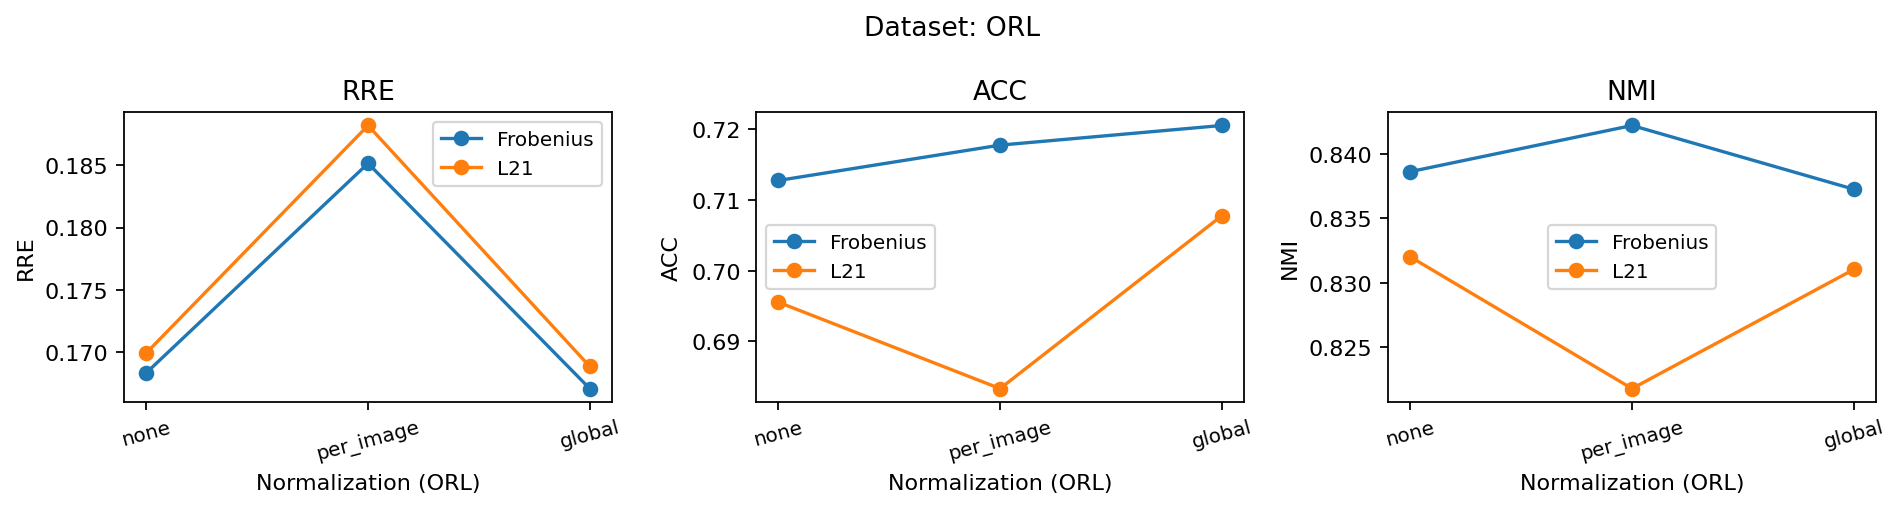

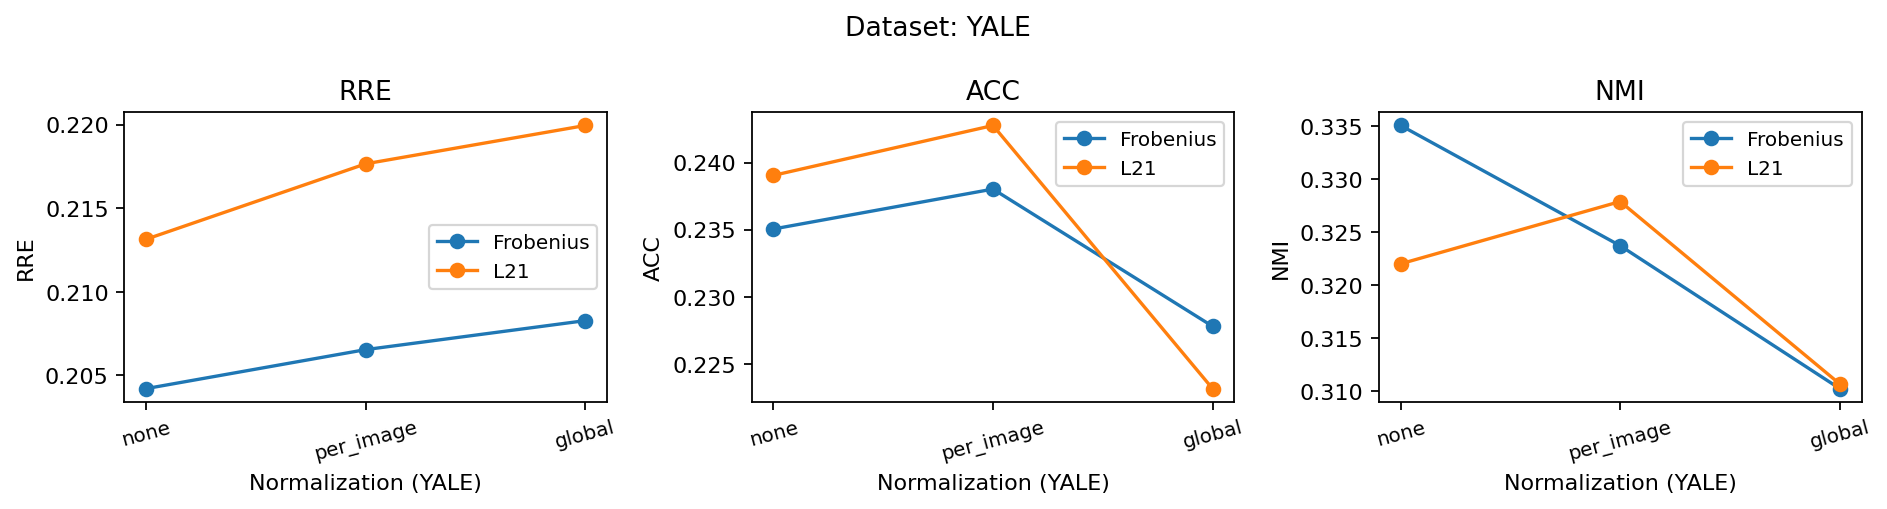

In [ ]:
plot_results_normalization(result)

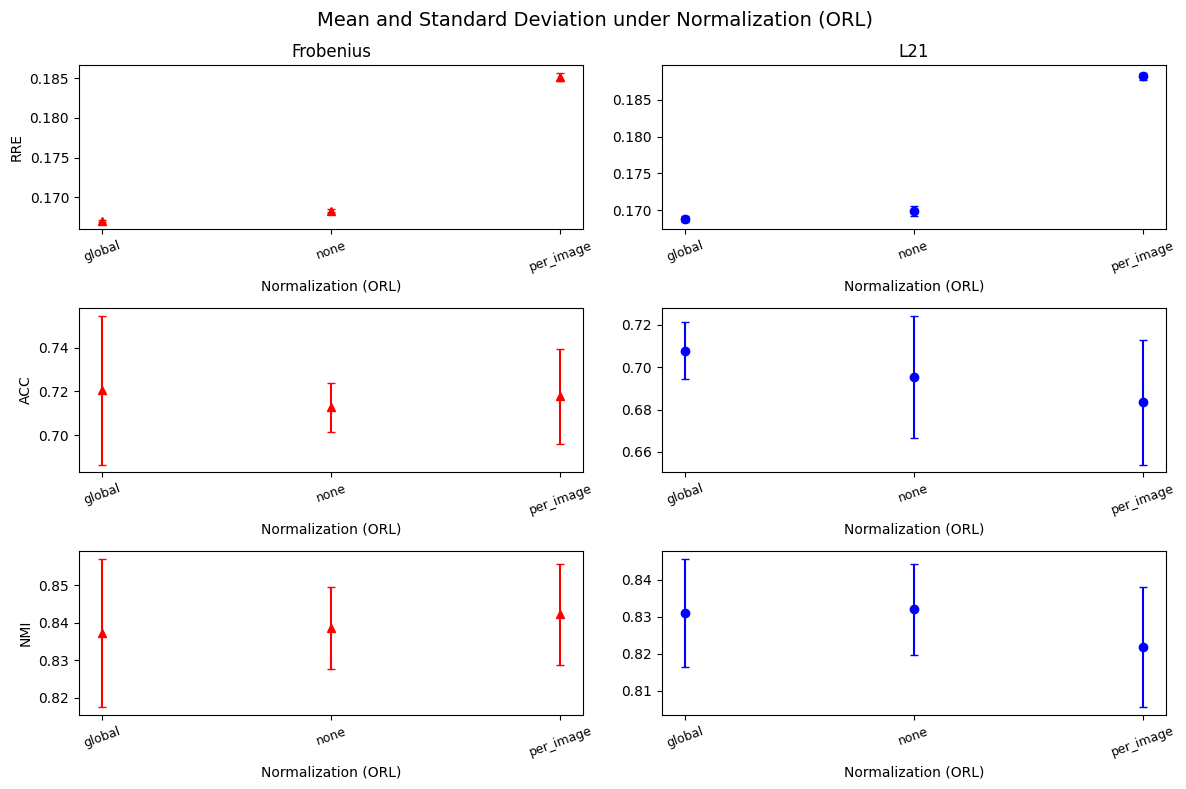

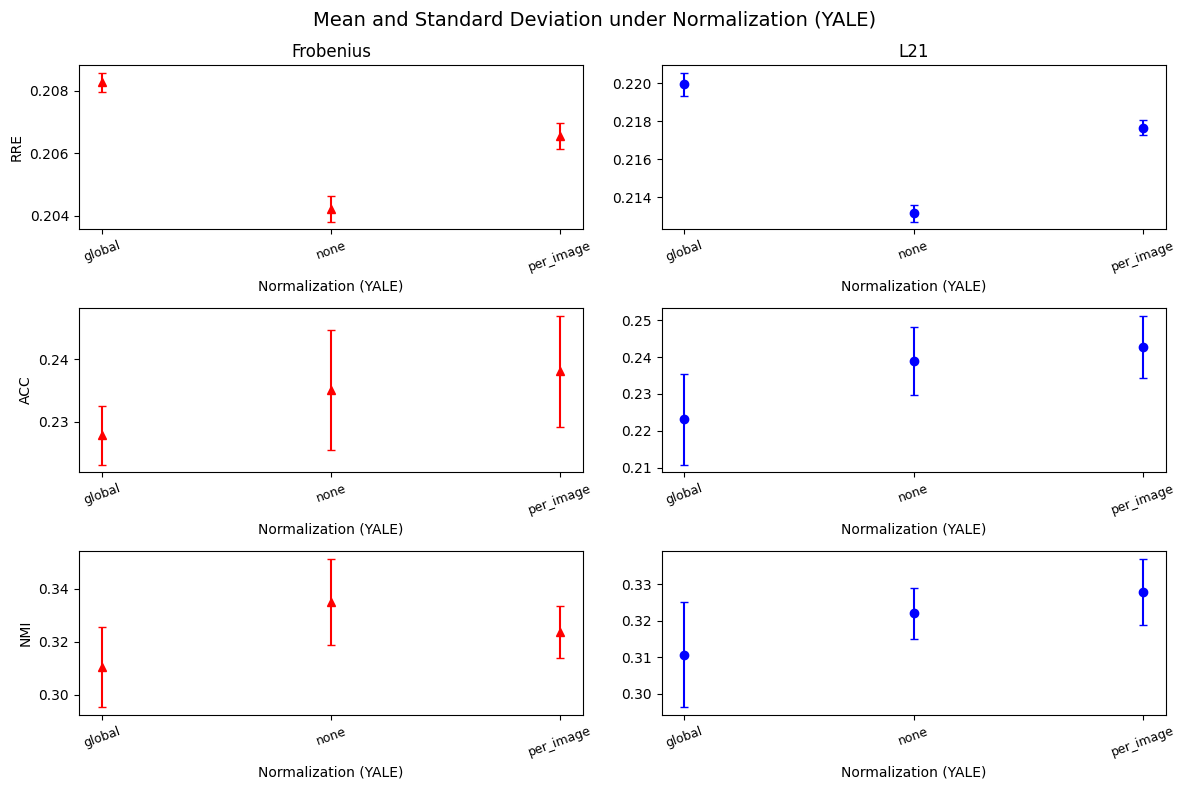

In [ ]:
plot_results_deviation_normalization(df, dataset = "ORL")
plot_results_deviation_normalization(df, dataset = "YALE")

### 3.2 Experiment about rank

In [ ]:
def generic_plot_results_deviation(result, x_label, label_names, dataset):
    df = pd.DataFrame(result)
    methods = df["nmf_type"].unique()
    metrics = [
        ("RRE", "RRE_mean", "RRE_std"),
        ("ACC", "ACC_mean", "ACC_std"),
        ("NMI", "NMI_mean", "NMI_std"),
    ]
    colors = {"Frobenius": "r", "L21": "b"}
    markers = {"Frobenius": "^", "L21": "o"}
    fig, axes = plt.subplots(len(metrics), len(methods), figsize=(12, 8), sharex=False)
    for col, method in enumerate(methods):
        sub_df = df[(df["dataset"] == dataset) & (df["nmf_type"] == method)]
        sub_df = sub_df.copy()
        if isinstance(label_names, dict):
            sub_df["label"] = sub_df.apply(lambda x: ', '.join([f"{l}={a[label_names[l]]}" for l in label_names]), axis=1)
            sub_df = sub_df.sort_values(list(label_names.values()))
        elif isinstance(label_names, str):
            sub_df["label"] = sub_df[label_names]
            sub_df = sub_df.sort_values(label_names)
        for row, (metric, mean_col, std_col) in enumerate(metrics):
            ax = axes[row, col] if len(methods) > 1 else axes[row]
            ax.errorbar(
                sub_df["label"],
                sub_df[mean_col],
                yerr=sub_df[std_col],
                fmt=markers[method],
                color=colors[method],
                capsize=3,
                label=method
            )
            if row == 0:
                ax.set_title(method)
            if col == 0:
                ax.set_ylabel(metric)
            ax.set_xlabel(f"{x_label} ({dataset})")
            ax.tick_params(axis="x", rotation=30, labelsize=8)

    plt.suptitle(f"Mean and Standard Deviation under Salt & Pepper Noise ({dataset})", fontsize=14)
    plt.tight_layout()
    plt.show()

def generic_plot_results_deviation(result, x_label, label_names, dataset):
    df = pd.DataFrame(result)
    methods = df["nmf_type"].unique()
    metrics = [
        ("RRE", "RRE_mean", "RRE_std"),
        ("ACC", "ACC_mean", "ACC_std"),
        ("NMI", "NMI_mean", "NMI_std"),
    ]
    colors = {"Frobenius": "r", "L21": "b"}
    markers = {"Frobenius": "^", "L21": "o"}
    fig, axes = plt.subplots(len(metrics), len(methods), figsize=(12, 8), sharex=False)
    for col, method in enumerate(methods):
        sub_df = df[(df["dataset"] == dataset) & (df["nmf_type"] == method)]
        sub_df = sub_df.copy()
        if isinstance(label_names, dict):
            sub_df["label"] = sub_df.apply(lambda x: ', '.join([f"{l}={a[label_names[l]]}" for l in label_names]), axis=1)
            sub_df = sub_df.sort_values(list(label_names.values()))
        elif isinstance(label_names, str):
            sub_df["label"] = sub_df[label_names]
            sub_df = sub_df.sort_values(label_names)
        for row, (metric, mean_col, std_col) in enumerate(metrics):
            ax = axes[row, col] if len(methods) > 1 else axes[row]
            ax.errorbar(
                sub_df["label"],
                sub_df[mean_col],
                yerr=sub_df[std_col],
                fmt=markers[method],
                color=colors[method],
                capsize=3,
                label=method
            )
            if row == 0:
                ax.set_title(method)
            if col == 0:
                ax.set_ylabel(metric)
            ax.set_xlabel(f"{x_label} ({dataset})")
            ax.tick_params(axis="x", rotation=30, labelsize=8)

    plt.suptitle(f"Mean and Standard Deviation under Salt & Pepper Noise ({dataset})", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_results(result, legend_name=None):
    """
    Draw the RRE / ACC / NMI curves based on the result.
    """
    if legend_name is None:
        legend_name = {"L21": "L21", "Frobenius": "Frobenius"}

    by_ds = defaultdict(lambda: defaultdict(list))
    for r in result:
        by_ds[r["dataset"]][r["nmf_type"]].append(r)

    for ds, method_rows in by_ds.items():
        for m in method_rows:
            method_rows[m] = sorted(method_rows[m], key=lambda x: x["k"])

        plt.figure(figsize=(12, 3.2), dpi=160)

        def draw(ax, metric, ylabel):
            mean_key = f"{metric}_mean"
            for m, arr in method_rows.items():
                ks = [a["k"] for a in arr]
                ys = [a[mean_key] for a in arr]
                ax.plot(ks, ys, marker='o', label=legend_name.get(m, m))
            ax.set_xlabel("Number of components")
            ax.set_ylabel(ylabel)
            ax.set_title(ylabel)
            ax.set_xticks(list(range(10, 142, 20)))
            ax.set_xlim(10, 142)
            ax.legend(loc="best", frameon=True, fontsize=9, handlelength=2, markerscale=1.0)
        # RRE / ACC / NMI
        draw(plt.subplot(1, 3, 1), "RRE", "RRE")
        draw(plt.subplot(1, 3, 2), "ACC", "ACC")
        draw(plt.subplot(1, 3, 3), "NMI", "NMI")
        plt.suptitle(f"Dataset: {ds}", fontsize=12)
        plt.tight_layout()
        plt.show()

def plot_results_deviation(df, dataset):
    methods = df["nmf_type"].unique()
    metrics = [
        ("RRE", "RRE_mean", "RRE_std"),
        ("ACC", "ACC_mean", "ACC_std"),
        ("NMI", "NMI_mean", "NMI_std"),
    ]
    colors = {"Frobenius": "r", "L21": "b"}
    markers = {"Frobenius": "^", "L21": "D"}
    fig, axes = plt.subplots(len(metrics), len(methods), figsize=(12, 8))
    for col, method in enumerate(methods):
        sub_df = df[(df["dataset"] == dataset) & (df["nmf_type"] == method)]
        sub_df = sub_df.sort_values("k")
        for row, (metric, mean_col, std_col) in enumerate(metrics):
            ax = axes[row, col]
            ax.errorbar(
                sub_df["k"],
                sub_df[mean_col],
                yerr=sub_df[std_col],
                fmt=markers[method],
                color=colors[method],
                capsize=3,
                label=method
            )
            if row == 0:
                ax.set_title(method)
            if col == 0:
                ax.set_ylabel(metric)
            ax.set_xlabel("Number of components")

    plt.suptitle(f"Mean and Standard Deviation ({dataset})", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
# experiment about rank on ORL and yale
datasets = ["ORL", "YALE"]
k_grid   = list(range(10, 141, 10))
methods  = ["Frobenius", "L21"]
# create each cfg
configs = []
for ds in datasets:
    for m in methods:
        for k in k_grid:
            cfg = {**base, "dataset": ds, "nmf_type": m, "rank": k}
            configs.append(cfg)

result = run_configs_parallel(configs, n_jobs=-1, backend="loky", verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 10
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 20
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 30
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 40
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.4s


dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 130
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 140
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 10
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 20
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 30
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   58.9s


dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 70
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 80
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 90
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 100
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 110
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset:

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.0min


dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 10
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 20
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 30
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 40
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.4min


dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 100
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 110
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 120
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 130
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 140
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
r

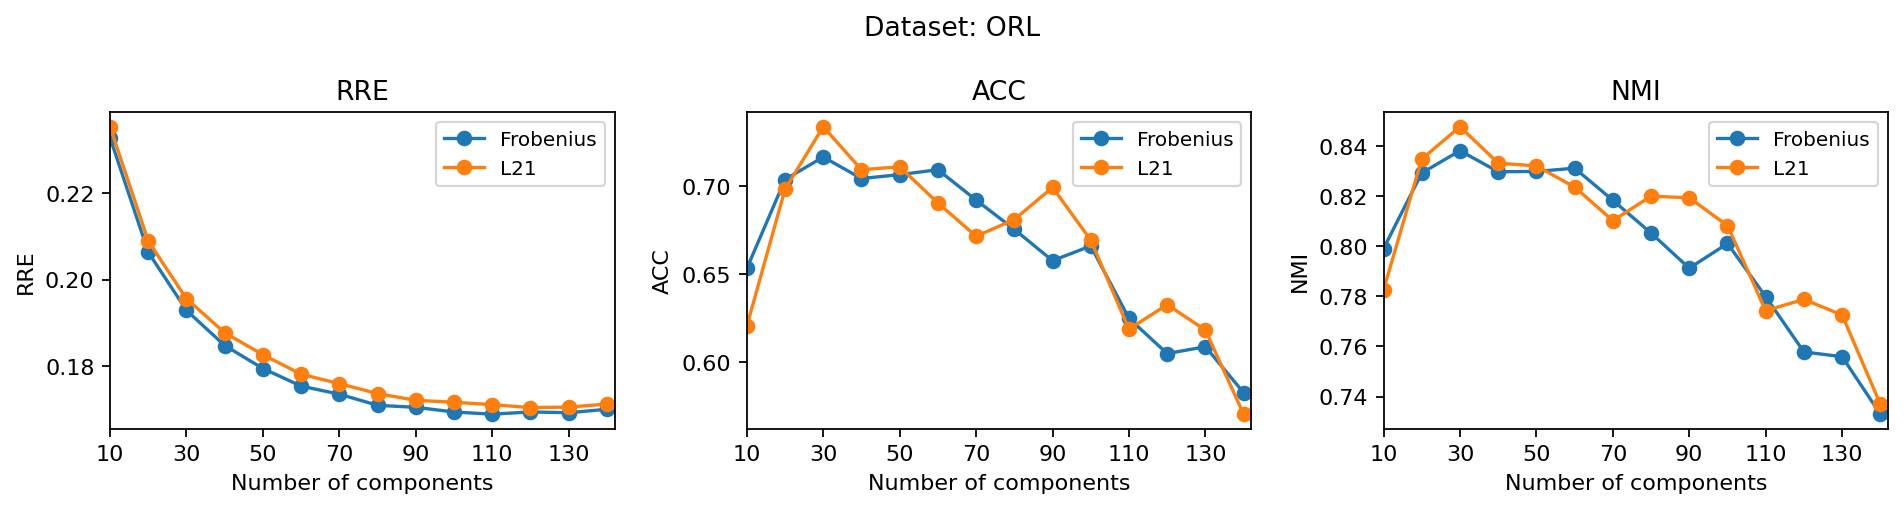

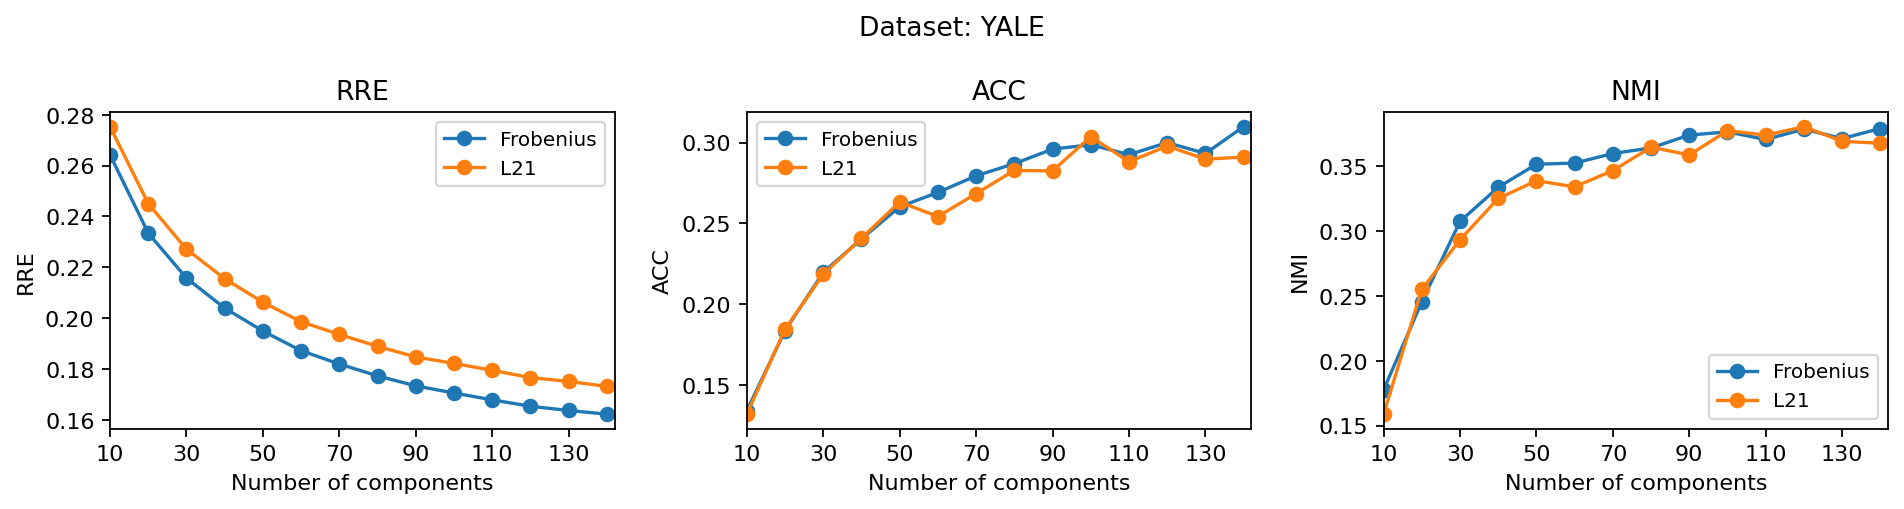

In [ ]:
plot_results(result)


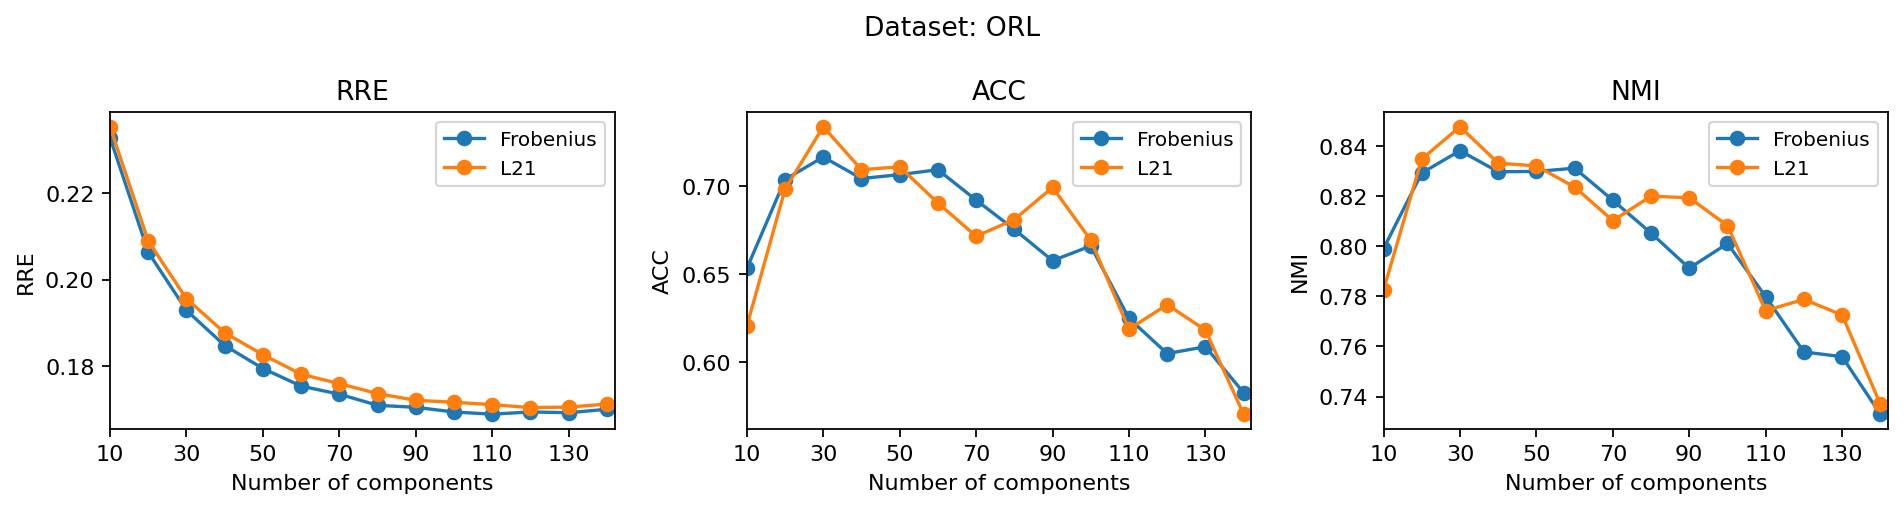

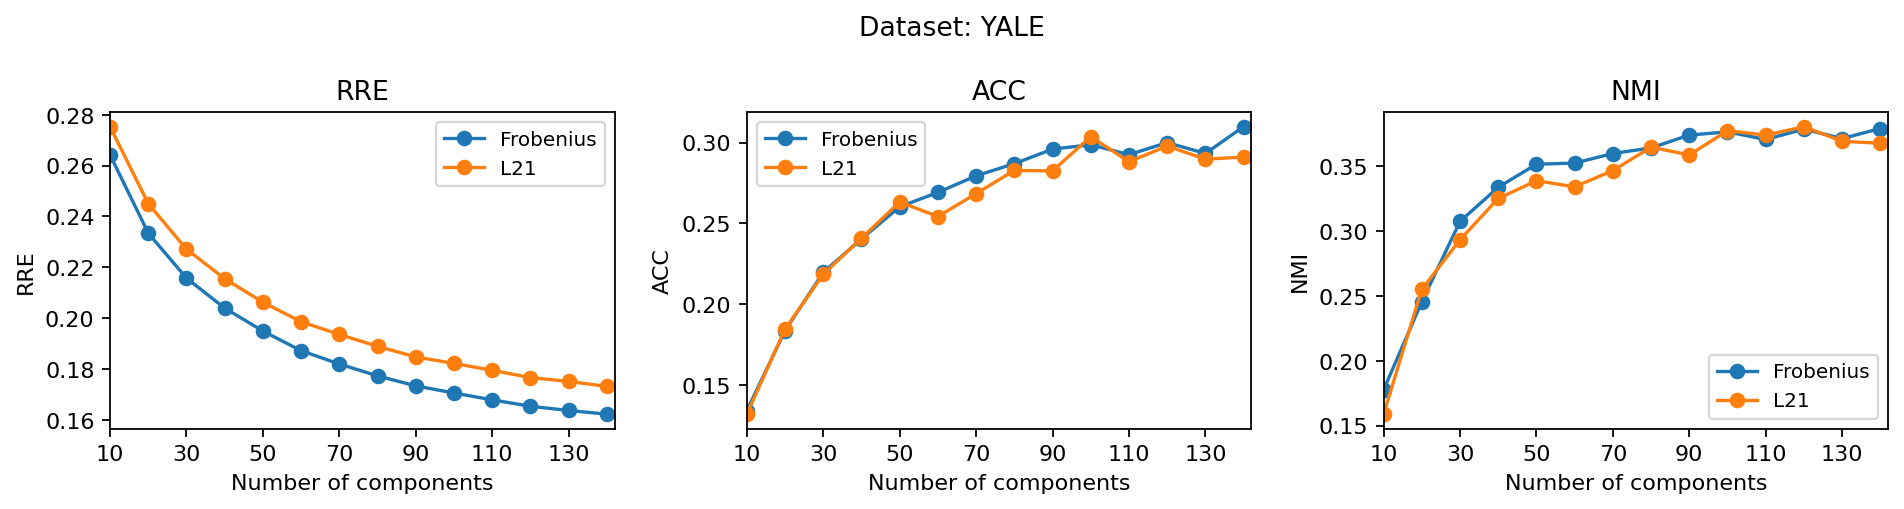

In [ ]:
def plot_results(result, legend_name=None):
    """
    Draw the RRE / ACC / NMI curves based on the result.
    """
    if legend_name is None:
        legend_name = {"L21": "L21", "Frobenius": "Frobenius"}

    by_ds = defaultdict(lambda: defaultdict(list))
    for r in result:
        by_ds[r["dataset"]][r["nmf_type"]].append(r)

    for ds, method_rows in by_ds.items():
        for m in method_rows:
            method_rows[m] = sorted(method_rows[m], key=lambda x: x["k"])

        plt.figure(figsize=(12, 3.2), dpi=160)

        def draw(ax, metric, ylabel):
            mean_key = f"{metric}_mean"
            for m, arr in method_rows.items():
                ks = [a["k"] for a in arr]
                ys = [a[mean_key] for a in arr]
                ax.plot(ks, ys, marker='o', label=legend_name.get(m, m))
            ax.set_xlabel("Number of components")
            ax.set_ylabel(ylabel)
            ax.set_title(ylabel)
            ax.set_xticks(list(range(10, 142, 20)))
            ax.set_xlim(10, 142)
            ax.legend(loc="best", frameon=True, fontsize=9, handlelength=2, markerscale=1.0)
        # RRE / ACC / NMI
        draw(plt.subplot(1, 3, 1), "RRE", "RRE")
        draw(plt.subplot(1, 3, 2), "ACC", "ACC")
        draw(plt.subplot(1, 3, 3), "NMI", "NMI")
        plt.suptitle(f"Dataset: {ds}", fontsize=12)
        plt.tight_layout()
        plt.show()

plot_results(result)     


In [ ]:
(result, 'Number of components', 'k', legend_name=None)

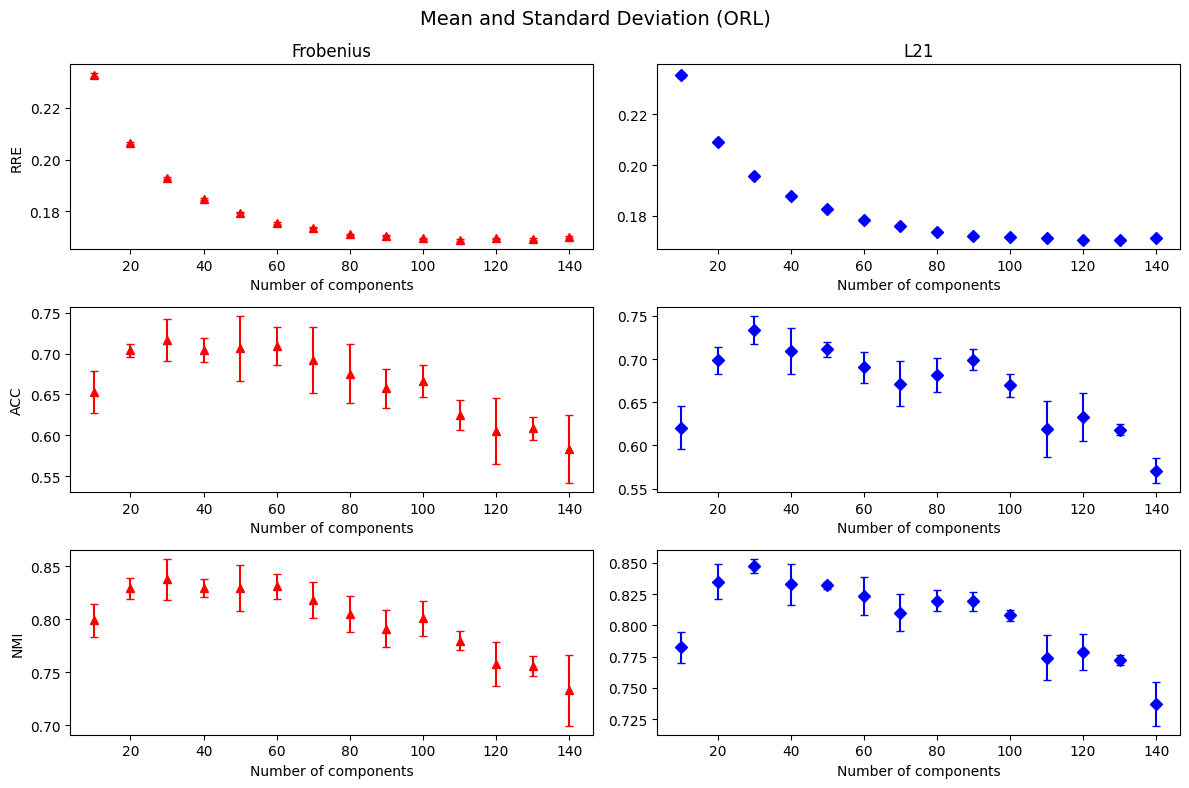

In [ ]:
df = pd.DataFrame(result)
plot_results_deviation(df, dataset="ORL")

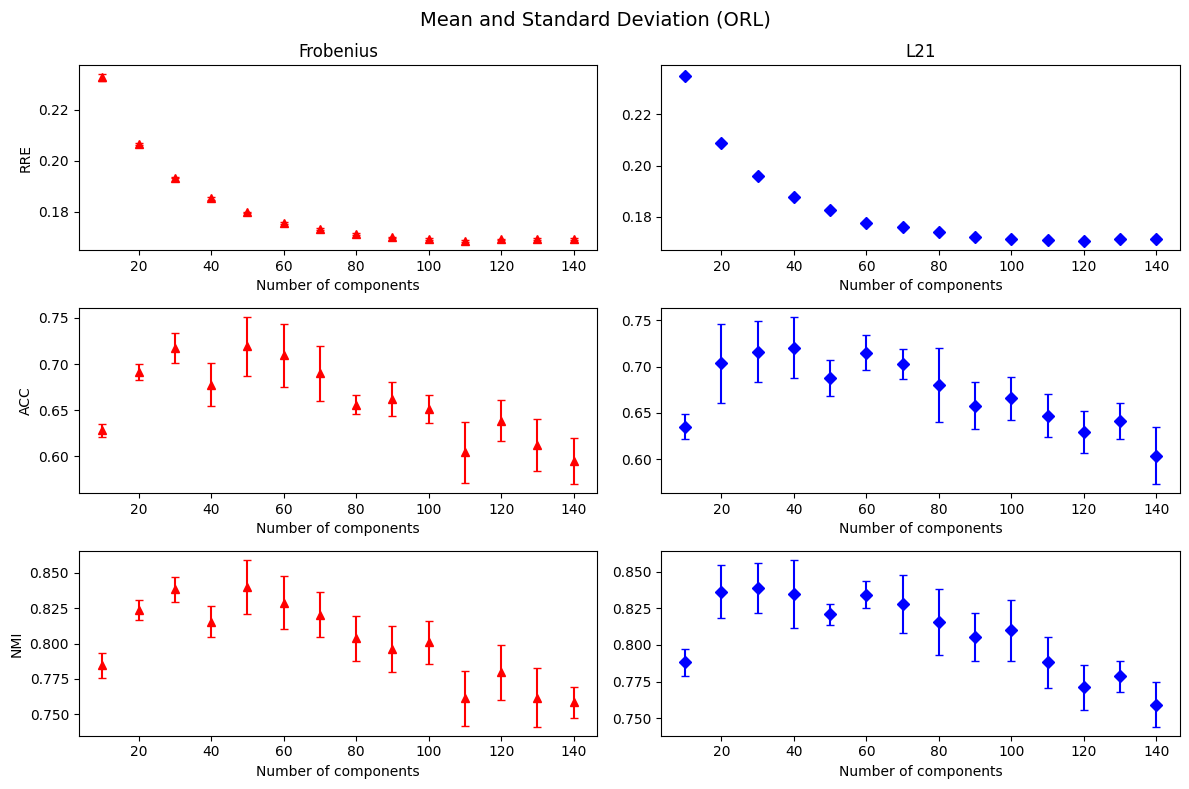

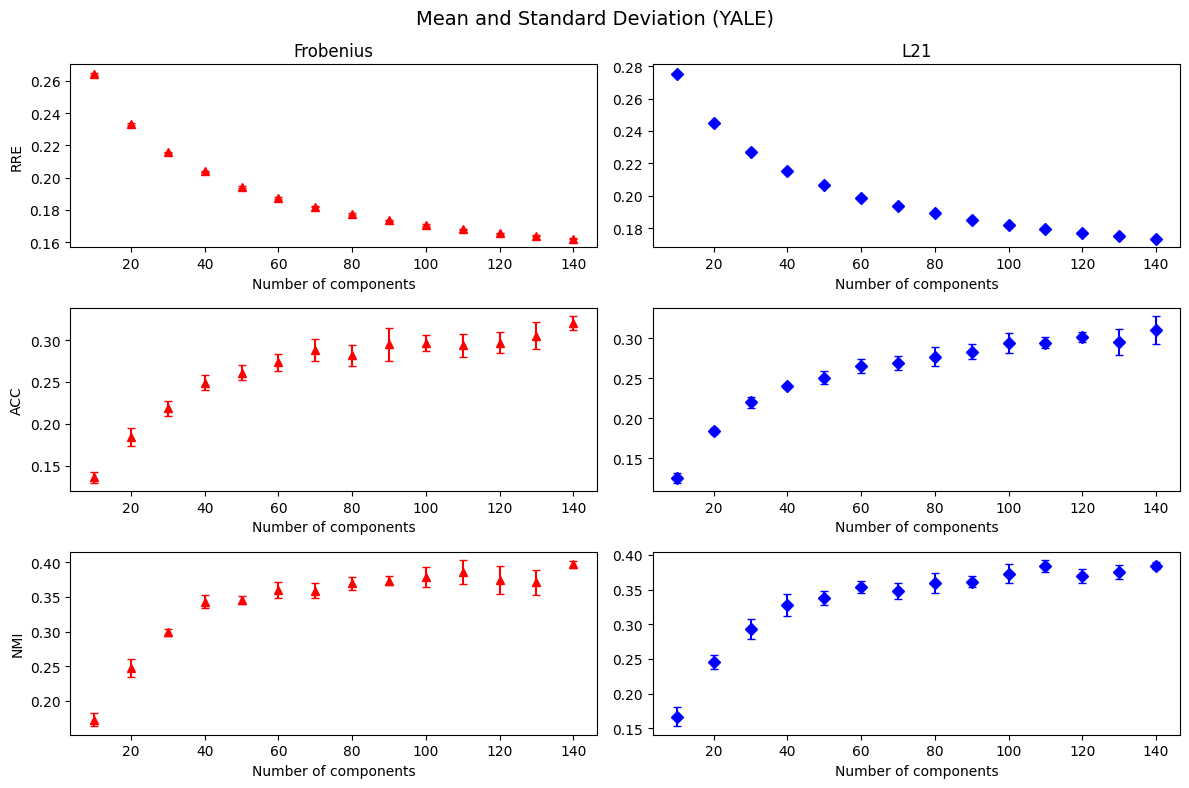

In [ ]:
df = pd.DataFrame(result)
plot_results_deviation(df, dataset="ORL")
plot_results_deviation(df, dataset="YALE")

In [ ]:
label_names = 'k'
x_label = 'Number of Components'
generic_plot_results_deviation(result, x_label, label_names, dataset="ORL")

In [ ]:
generic_plot_results_deviation(result, x_label, label_names, dataset="YALE")

### 3.3 Robustness to noise

In [ ]:
def plot_results_noise(result, legend_name=None):
    """
    Draw the RRE / ACC / NMI curves based on the result,
    with x-axis = noise configs (P, R).
    """
    if legend_name is None:
        legend_name = {"L21": "L21", "Frobenius": "Frobenius"}
    by_ds = defaultdict(lambda: defaultdict(list))
    for r in result:
        by_ds[r["dataset"]][r["nmf_type"]].append(r)
    for dataset, method_rows in by_ds.items():
        for m in method_rows:
            method_rows[m] = sorted(method_rows[m], key=lambda x: (x["noise_p"], x["noise_r"]))
        plt.figure(figsize=(12, 3.2), dpi=160)
        def draw(ax, metric, ylabel):
            mean_key = f"{metric}_mean"
            for m, arr in method_rows.items():
                labels = [f"P={a['noise_p']}, R={a['noise_r']}" for a in arr]
                ys = [a[mean_key] for a in arr]
                ax.plot(labels, ys, marker='o', label=legend_name.get(m, m))
            ax.set_xlabel(f"Salt & Pepper Noise ({dataset})")
            ax.set_ylabel(ylabel)
            ax.set_title(ylabel)
            ax.tick_params(axis="x", rotation=30, labelsize=8)
            ax.legend(loc="best", frameon=True, fontsize=9, handlelength=2, markerscale=1.0)
        # RRE / ACC / NMI
        draw(plt.subplot(1, 3, 1), "RRE", "RRE")
        draw(plt.subplot(1, 3, 2), "ACC", "ACC")
        draw(plt.subplot(1, 3, 3), "NMI", "NMI")
        plt.suptitle(f"Dataset: {dataset}", fontsize=12)
        plt.tight_layout()
        plt.show()
        
def plot_results_deviation_noise(df, dataset):
    methods = df["nmf_type"].unique()
    metrics = [
        ("RRE", "RRE_mean", "RRE_std"),
        ("ACC", "ACC_mean", "ACC_std"),
        ("NMI", "NMI_mean", "NMI_std"),
    ]
    colors = {"Frobenius": "r", "L21": "b"}
    markers = {"Frobenius": "^", "L21": "o"}
    fig, axes = plt.subplots(len(metrics), len(methods), figsize=(12, 8), sharex=False)
    for col, method in enumerate(methods):
        sub_df = df[(df["dataset"] == dataset) & (df["nmf_type"] == method)]
        sub_df = sub_df.copy()
        sub_df["label"] = sub_df.apply(lambda x: f"P={x['noise_p']}, R={x['noise_r']}", axis=1)
        sub_df = sub_df.sort_values(["noise_p", "noise_r"])
        for row, (metric, mean_col, std_col) in enumerate(metrics):
            ax = axes[row, col] if len(methods) > 1 else axes[row]
            ax.errorbar(
                sub_df["label"],
                sub_df[mean_col],
                yerr=sub_df[std_col],
                fmt=markers[method],
                color=colors[method],
                capsize=3,
                label=method
            )
            if row == 0:
                ax.set_title(method)
            if col == 0:
                ax.set_ylabel(metric)
            ax.set_xlabel(f"Salt & Pepper Noise ({dataset})")
            ax.tick_params(axis="x", rotation=30, labelsize=8)

    plt.suptitle(f"Mean and Standard Deviation under Salt & Pepper Noise ({dataset})", fontsize=14)
    plt.tight_layout()
    plt.show()
    
def log_experiment(df, filename="experiment_results.txt"):
    """
    Record the experimental result
    """
    mode = "a" if os.path.exists(filename) else "w"
    with open(filename, mode) as f:
        if mode == "w":  # first record
            f.write("===== Experiment Log Start =====\n\n")
        f.write("===== New Experiment =====\n")
        f.write(df.to_string(index=False))
        f.write("\n\n")

In [44]:
methods  = ["Frobenius", "L21"]
# create each cfg
sp_noise_combos = [
    (0.01, 0.5), 
    (0.05, 0.3), 
    (0.1, 0.5),   
    (0.1, 0.7),  
    (0.2, 0.5),   
    (0.3, 0.3),  
    (0.3, 0.7),   
]
configs = []
for m in methods:
    for p, r in sp_noise_combos:
        cfg = {
            **base,
            "dataset": "ORL",
            "nmf_type": m,
            "rank": 50,
            "noise_p": p,
            "noise_r": r,
            "noise_type": "salt_pepper"
        }
        configs.append(cfg)

result = run_configs_parallel(configs, n_jobs=-1, backend="loky", verbose=10)
df = pd.DataFrame(result)
salt_df = df[df["noise_type"] == "salt_pepper"]
log_experiment(salt_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.01
noise_r: 0.5
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.3
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.1
noise_r: 0.5
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.1
noise_r: 0.7
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.2
noise_r: 0.5
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3

[Parallel(n_jobs=-1)]: Done   3 out of  14 | elapsed:   31.1s remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:   38.2s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:   48.0s remaining:   48.0s
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:   54.6s remaining:   30.3s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:   56.5s remaining:   15.4s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  1.0min finished


In [45]:
res = result.copy()
by_ds = defaultdict(lambda: defaultdict(list))
for r in res:
    by_ds[r["dataset"]][r["nmf_type"]].append(r)
for dataset, method_rows in by_ds.items():
    for m in method_rows:
        print(m)
        print(method_rows[m])
        print(method_rows[m] == sorted(method_rows[m], key=lambda x: (x["noise_p"], x["noise_r"])))
        method_rows[m] = sorted(method_rows[m], key=lambda x: (x["noise_p"], x["noise_r"]))
        print(method_rows[m])

Frobenius
[{'dataset': 'ORL', 'nmf_type': 'Frobenius', 'k': 50, 'max_runs': 5, 'RRE_mean': np.float64(0.16161549661399355), 'RRE_std': np.float64(0.00030485659361688795), 'ACC_mean': np.float64(0.7138888888888888), 'ACC_std': np.float64(0.02270312971300284), 'NMI_mean': np.float64(0.8378411910693903), 'NMI_std': np.float64(0.012542645436617724), 'noise_type': 'salt_pepper', 'noise_p': 0.01, 'noise_r': 0.5, 'normalization': 'per_image'}, {'dataset': 'ORL', 'nmf_type': 'Frobenius', 'k': 50, 'max_runs': 5, 'RRE_mean': np.float64(0.1807461955466369), 'RRE_std': np.float64(0.0004438921894628053), 'ACC_mean': np.float64(0.7044444444444444), 'ACC_std': np.float64(0.018970412309959873), 'NMI_mean': np.float64(0.8333377483154868), 'NMI_std': np.float64(0.014896799566831364), 'noise_type': 'salt_pepper', 'noise_p': 0.05, 'noise_r': 0.3, 'normalization': 'per_image'}, {'dataset': 'ORL', 'nmf_type': 'Frobenius', 'k': 50, 'max_runs': 5, 'RRE_mean': np.float64(0.20403384808190528), 'RRE_std': np.flo

In [46]:
label_names = ['noise_p', 'noise_r']
for dataset, method_rows in by_ds.items():
    for m, arr in method_rows.items():
        labels = [f"P={a['noise_p']}, R={a['noise_r']}" for a in arr]
        print(labels)
        labels = [str([f"{l[-1:].upper()}={a[l]}" for l in label_names]) for a in arr]
        print(labels)


['P=0.01, R=0.5', 'P=0.05, R=0.3', 'P=0.1, R=0.5', 'P=0.1, R=0.7', 'P=0.2, R=0.5', 'P=0.3, R=0.3', 'P=0.3, R=0.7']
["['P=0.01', 'R=0.5']", "['P=0.05', 'R=0.3']", "['P=0.1', 'R=0.5']", "['P=0.1', 'R=0.7']", "['P=0.2', 'R=0.5']", "['P=0.3', 'R=0.3']", "['P=0.3', 'R=0.7']"]
['P=0.01, R=0.5', 'P=0.05, R=0.3', 'P=0.1, R=0.5', 'P=0.1, R=0.7', 'P=0.2, R=0.5', 'P=0.3, R=0.3', 'P=0.3, R=0.7']
["['P=0.01', 'R=0.5']", "['P=0.05', 'R=0.3']", "['P=0.1', 'R=0.5']", "['P=0.1', 'R=0.7']", "['P=0.2', 'R=0.5']", "['P=0.3', 'R=0.3']", "['P=0.3', 'R=0.7']"]


In [100]:
label_names = {'P':'noise_p', 'R':'noise_r'}
list(label_names.values())

['noise_p', 'noise_r']

In [47]:
label_names = {'P':'noise_p', 'R':'noise_r'}
label_names = {'k':'k'}
for l in label_names:
    print(l)
for dataset, method_rows in by_ds.items():
    for m, arr in method_rows.items():
        labels = [f"P={a['noise_p']}, R={a['noise_r']}" for a in arr]
        print(labels)
        labels = [', '.join([f"{l}={a[label_names[l]]}" for l in label_names]) for a in arr]
        print(labels)

k
['P=0.01, R=0.5', 'P=0.05, R=0.3', 'P=0.1, R=0.5', 'P=0.1, R=0.7', 'P=0.2, R=0.5', 'P=0.3, R=0.3', 'P=0.3, R=0.7']
['k=50', 'k=50', 'k=50', 'k=50', 'k=50', 'k=50', 'k=50']
['P=0.01, R=0.5', 'P=0.05, R=0.3', 'P=0.1, R=0.5', 'P=0.1, R=0.7', 'P=0.2, R=0.5', 'P=0.3, R=0.3', 'P=0.3, R=0.7']
['k=50', 'k=50', 'k=50', 'k=50', 'k=50', 'k=50', 'k=50']


In [48]:
for dataset, method_rows in by_ds.items():
    print(method_rows)

defaultdict(<class 'list'>, {'Frobenius': [{'dataset': 'ORL', 'nmf_type': 'Frobenius', 'k': 50, 'max_runs': 5, 'RRE_mean': np.float64(0.16161549661399355), 'RRE_std': np.float64(0.00030485659361688795), 'ACC_mean': np.float64(0.7138888888888888), 'ACC_std': np.float64(0.02270312971300284), 'NMI_mean': np.float64(0.8378411910693903), 'NMI_std': np.float64(0.012542645436617724), 'noise_type': 'salt_pepper', 'noise_p': 0.01, 'noise_r': 0.5, 'normalization': 'per_image'}, {'dataset': 'ORL', 'nmf_type': 'Frobenius', 'k': 50, 'max_runs': 5, 'RRE_mean': np.float64(0.1807461955466369), 'RRE_std': np.float64(0.0004438921894628053), 'ACC_mean': np.float64(0.7044444444444444), 'ACC_std': np.float64(0.018970412309959873), 'NMI_mean': np.float64(0.8333377483154868), 'NMI_std': np.float64(0.014896799566831364), 'noise_type': 'salt_pepper', 'noise_p': 0.05, 'noise_r': 0.3, 'normalization': 'per_image'}, {'dataset': 'ORL', 'nmf_type': 'Frobenius', 'k': 50, 'max_runs': 5, 'RRE_mean': np.float64(0.20403

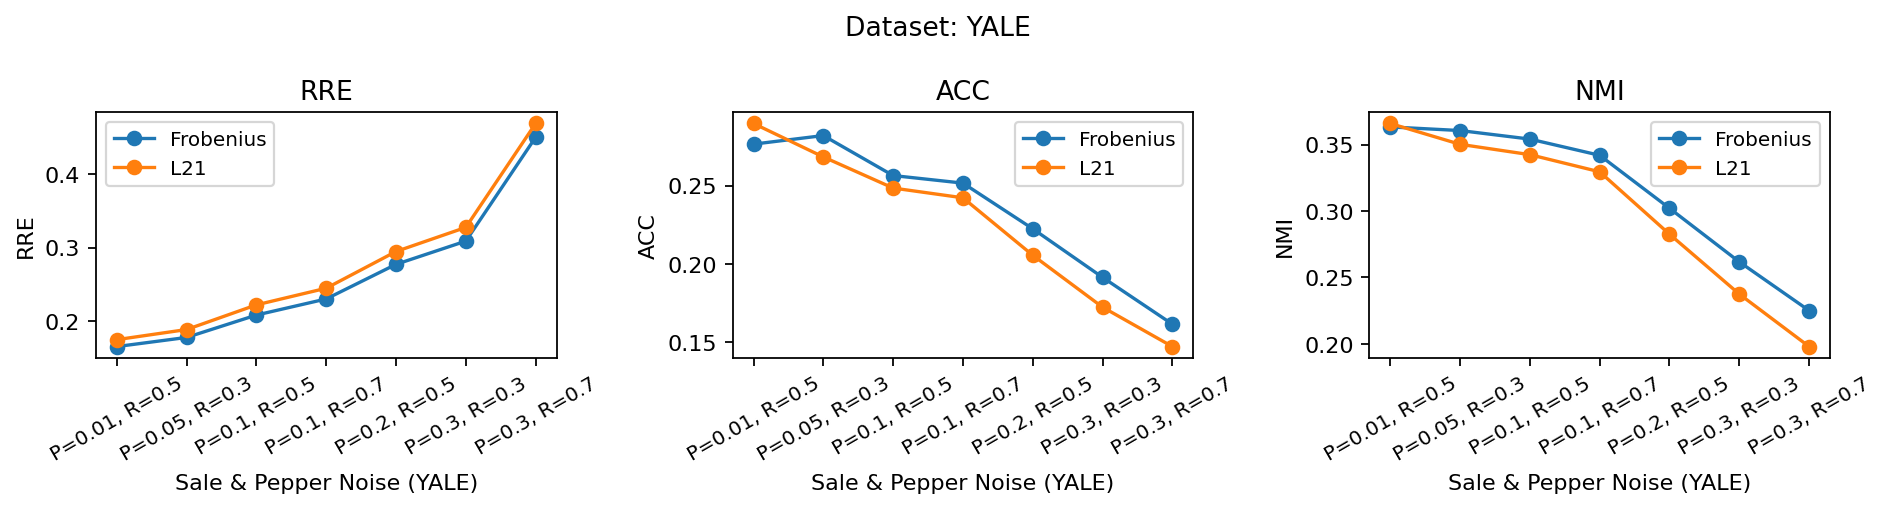

In [55]:
plot_results(result, 'Sale & Pepper Noise', {'P':'noise_p', 'R':'noise_r'}, legend_name=None)
label_names = {'P':'noise_p', 'R':'noise_r'}
generic_plot_results(result, 'Number of components', 'k', legend_name=None)

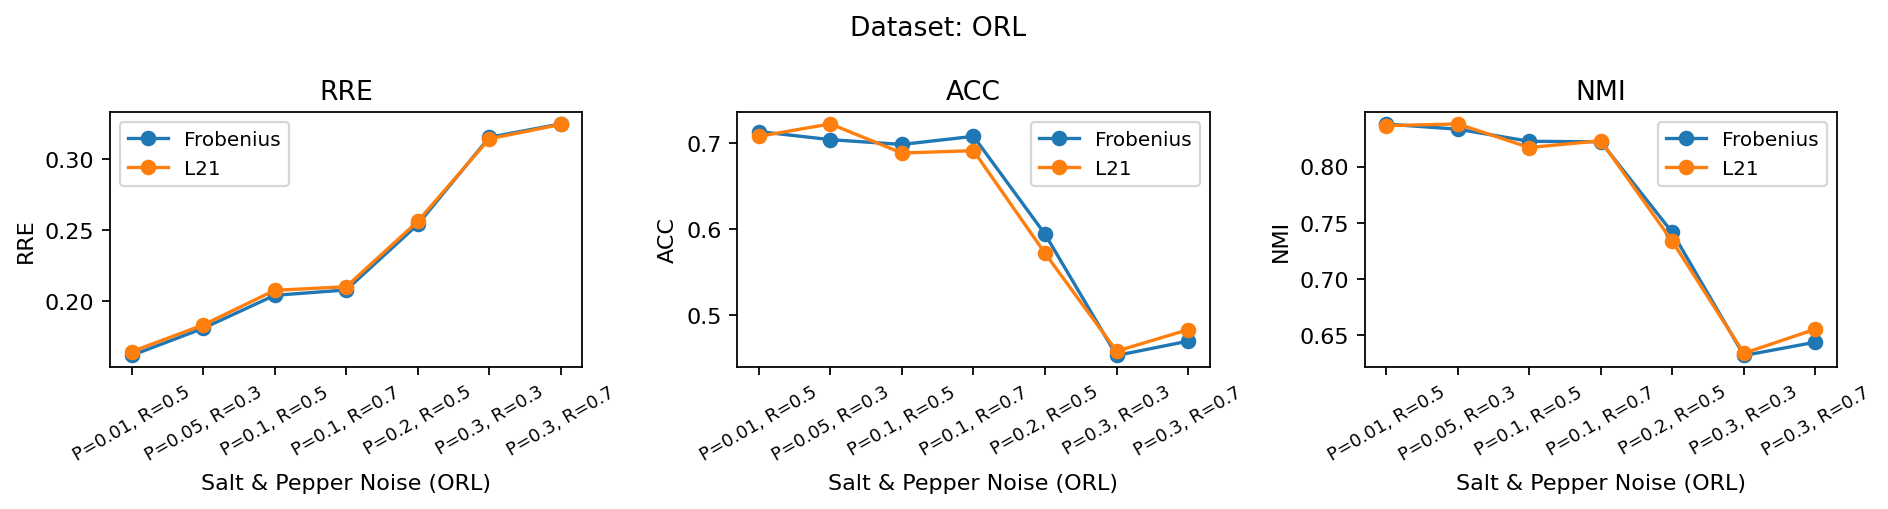

In [50]:
plot_results_noise(result)

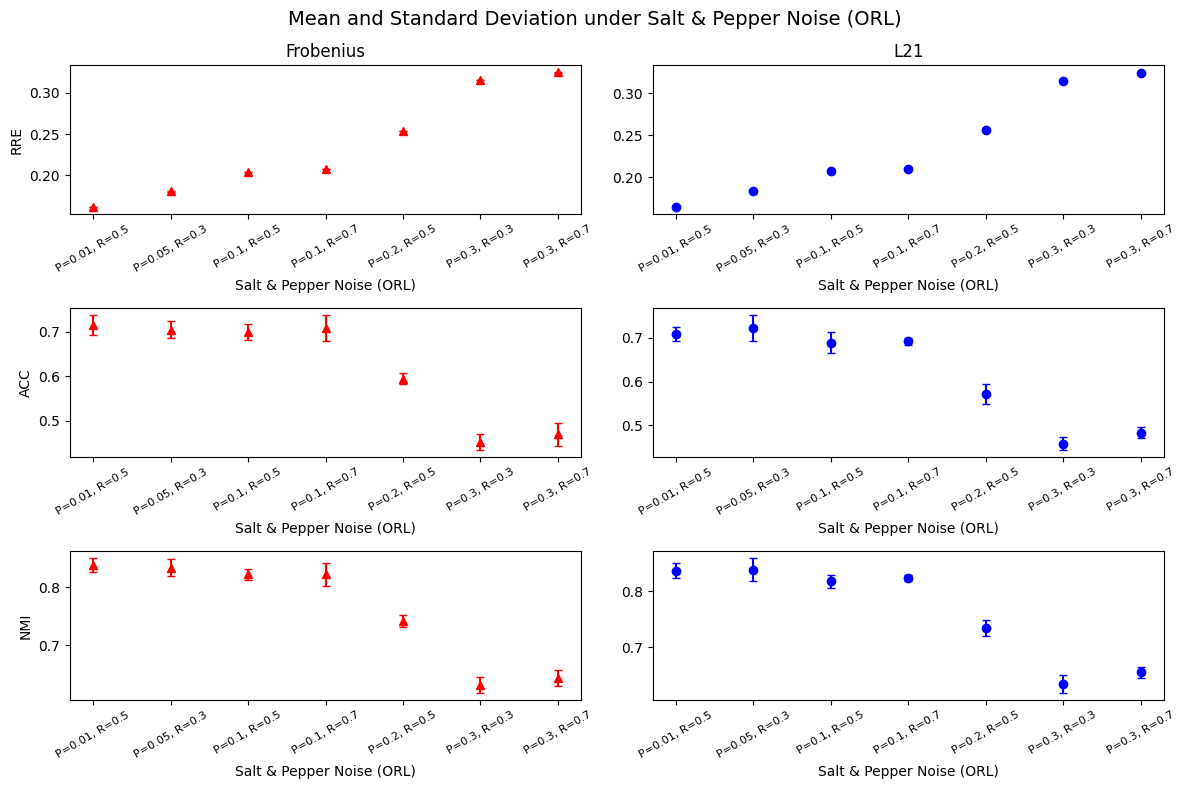

In [51]:
plot_results_deviation_noise(df, dataset="ORL")

In [52]:
configs = []
for m in methods:
    for p, r in sp_noise_combos:
        cfg = {
            **base,
            "dataset": "YALE",
            "nmf_type": m,
            "rank": 70,
            "noise_p": p,
            "noise_r": r,
            "max_iterations": 1000,
            "noise_type": "salt_pepper"
        }
        configs.append(cfg)
result = run_configs_parallel(configs, n_jobs=-1, backend="loky", verbose=10)
df = pd.DataFrame(result)
salt_df = df[df["noise_type"] == "salt_pepper"]
log_experiment(salt_df)
log_experiment(df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.01
noise_r: 0.5
nmf_type: Frobenius
rank: 70
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.3
nmf_type: Frobenius
rank: 70
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.1
noise_r: 0.5
nmf_type: Frobenius
rank: 70
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.1
noise_r: 0.7
nmf_type: Frobenius
rank: 70
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.2
noise_r: 0.5
nmf_type: Frobenius
rank: 70
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YA

[Parallel(n_jobs=-1)]: Done   3 out of  14 | elapsed:  4.3min remaining: 15.7min
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:  4.9min remaining:  8.9min
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:  5.5min remaining:  5.5min
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:  5.9min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:  6.8min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  7.5min finished


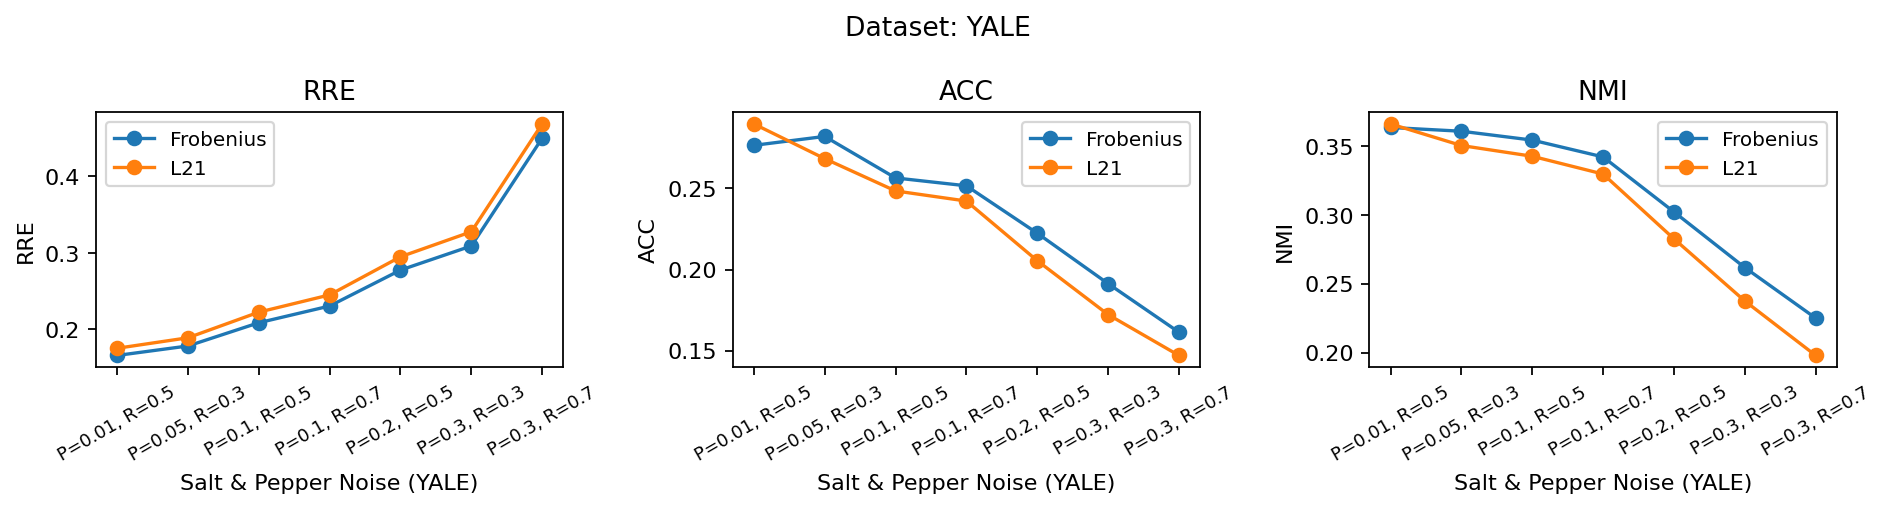

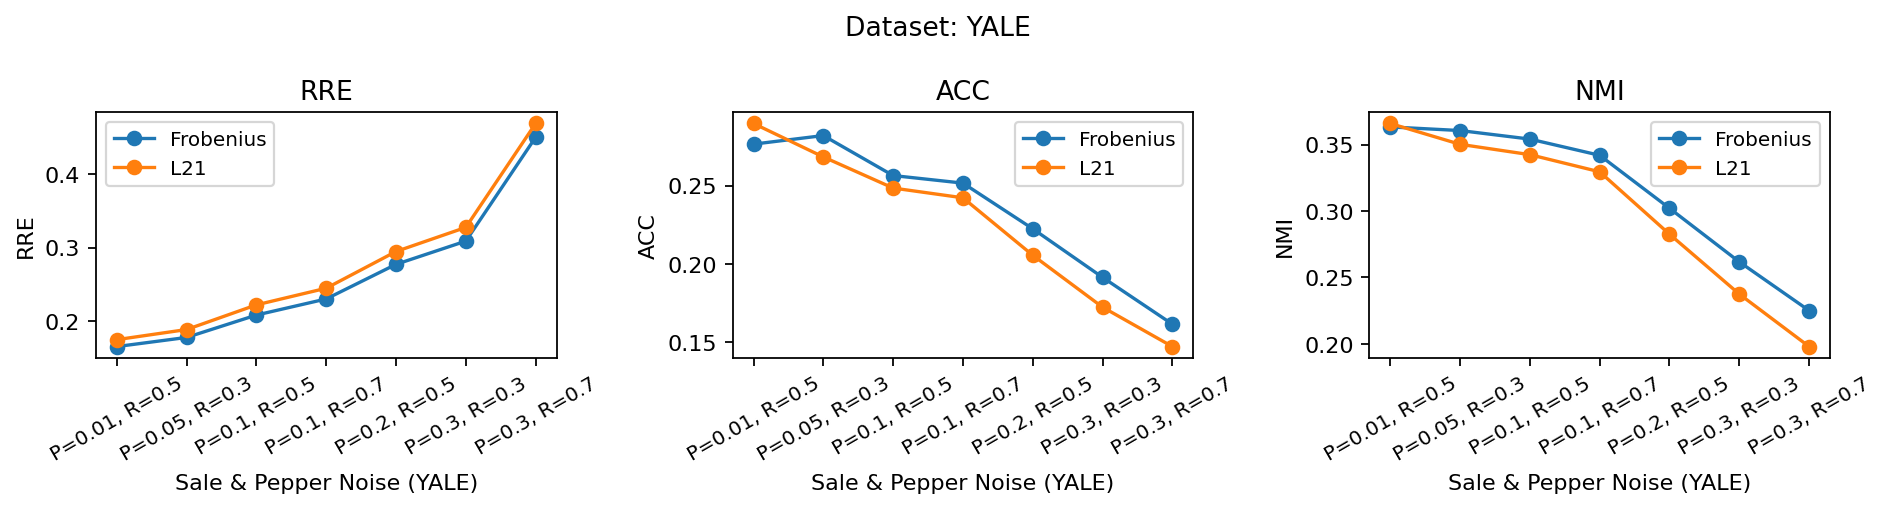

In [56]:
plot_results_noise(result)
plot_results(result, 'Sale & Pepper Noise', {'P':'noise_p', 'R':'noise_r'}, legend_name=None)

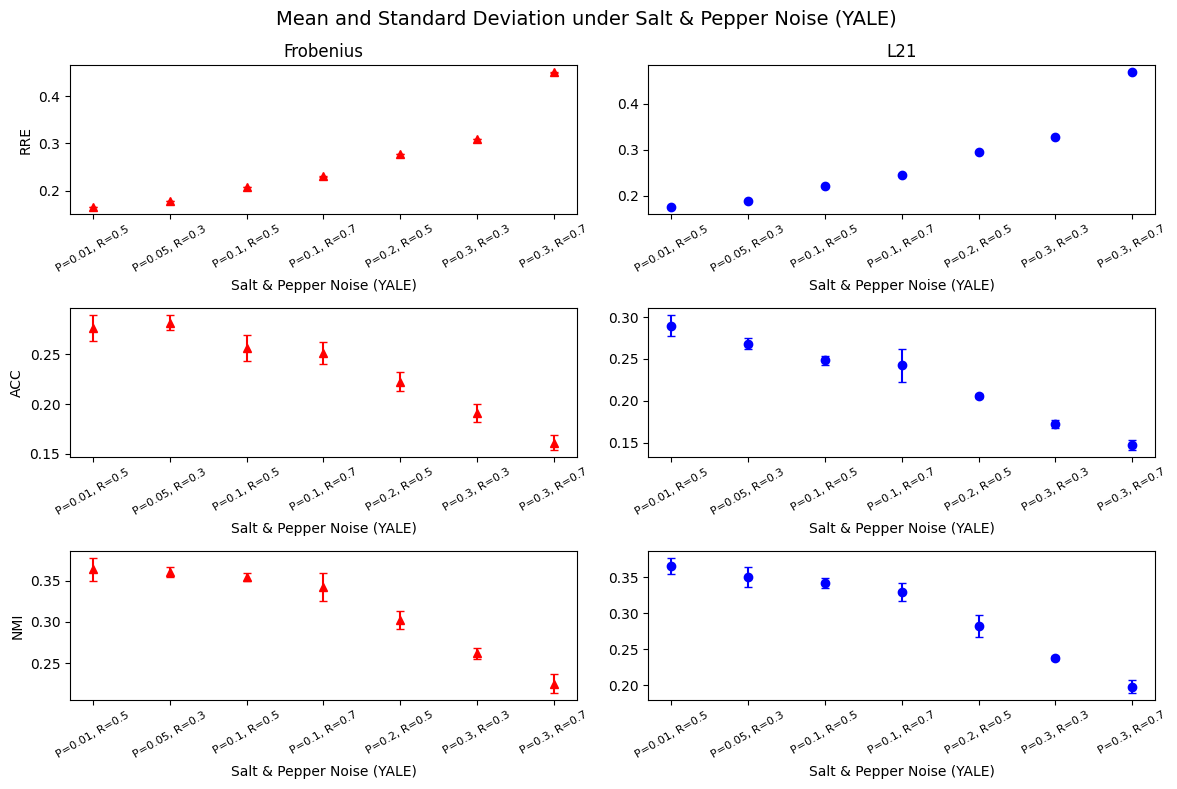

In [ ]:
plot_results_deviation_noise(df, dataset="YALE")
